# UGV obstacle aviodance

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import re
import os
import glob

## Data making

**Reading txt files (and pad)**

In [2]:
pwm_left = list()
pwm_right = list()
srf_right = list()
srf_left = list()

max_length = 120

for FolderName in [name for name in os.listdir("./Data robot Modified") if os.path.isdir(os.path.join("./Data robot Modified", name))]:
   path = f'./Data robot Modified/{FolderName}'
   for filename in glob.glob(os.path.join(path, 'pwm_left.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         for i in range(max_length-len(x)):
            x.insert(0,0)  # add zero at the begining
         pwm_left.append(x)
   
   for filename in glob.glob(os.path.join(path, 'pwm_right.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         for i in range(max_length-len(x)):
            x.insert(0,0)  # add zero at the begining
         pwm_right.append(x)
      
   for filename in glob.glob(os.path.join(path, 'right_srf.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         for i in range(max_length-len(x)):
            x.insert(0,0)  # add zero at the begining
         srf_right.append(x)
      
   for filename in glob.glob(os.path.join(path, 'left_srf.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         for i in range(max_length-len(x)):
            x.insert(0,0)  # add zero at the begining
         srf_left.append(x)
      
pwm_left = [pwm_left[i][j] for i in range(len(pwm_left)) for j in range(len(pwm_left[i]))]
pwm_right = [pwm_right[i][j] for i in range(len(pwm_right)) for j in range(len(pwm_right[i]))]
srf_left = [srf_left[i][j] for i in range(len(srf_left)) for j in range(len(srf_left[i]))]
srf_right = [srf_right[i][j] for i in range(len(srf_right)) for j in range(len(srf_right[i]))]

**Reading txt files**

In [ ]:
pwm_left = list()
pwm_right = list()
srf_right = list()
srf_left = list()

for FolderName in [name for name in os.listdir("./Data robot Modified") if os.path.isdir(os.path.join("./Data robot Modified", name))]:
   path = f'./Data robot Modified/{FolderName}'
   for filename in glob.glob(os.path.join(path, 'pwm_left.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         pwm_left.append(x)
   
   for filename in glob.glob(os.path.join(path, 'pwm_right.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         pwm_right.append(x)
      
   for filename in glob.glob(os.path.join(path, 'right_srf.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         srf_right.append(x)
      
   for filename in glob.glob(os.path.join(path, 'left_srf.txt')):
      with open(os.path.join(os.getcwd(), filename), 'r') as f:
         x = re.findall(r'-?\d+\.?\d*', f.read())
         x = [eval(x[i]) for i in range(len(x))] 
         srf_left.append(x)
      
pwm_left = [pwm_left[i][j] for i in range(len(pwm_left)) for j in range(len(pwm_left[i]))]
pwm_right = [pwm_right[i][j] for i in range(len(pwm_right)) for j in range(len(pwm_right[i]))]
srf_left = [srf_left[i][j] for i in range(len(srf_left)) for j in range(len(srf_left[i]))]
srf_right = [srf_right[i][j] for i in range(len(srf_right)) for j in range(len(srf_right[i]))]

## Speed to position function

In [3]:
def position(pwm_right, pwm_left):
    r = 0.02
    L2 = 1
    max_speed = 100
    Ts = 0.1
    heading = 0
    w = 0
    x = [0]
    y = [0]
    v_right = np.array([i*max_speed*r/100. for i in pwm_right])
    v_left = np.array([i*max_speed*r/100. for i in pwm_left])

    ## Vx = (v_right + v_left)*sin(heading)/2
    ## Vy = (v_right + v_left)*cos(heading)/2
    ## W = (v_left - v_right)/L2
    v_x = (v_right + v_left)/2
    v_y = (v_right + v_left)/2
    w = v_left - v_right
    w = [i/L2 for i in w]
    for i in range(len(v_x)-1):
        v_x[i] = v_x[i]*(np.sin(heading))
        x.append(v_x[i]*Ts+x[i])
        v_y[i] = v_y[i]*(np.cos(heading))
        y.append(v_y[i]*Ts+y[i])
        heading = w[i]*Ts+heading

    plt.plot(x[0],y[0],'r*')
    plt.plot(x[1:],y[1:])
    plt.plot(x[len(x)-1],y[len(x)-1],'g*')

    return x, y

**proposed paths for training (with pad)**

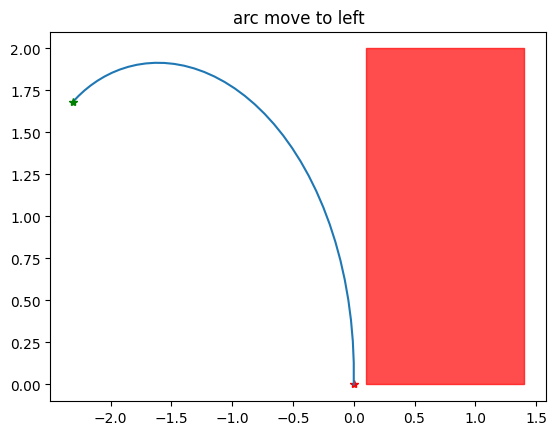

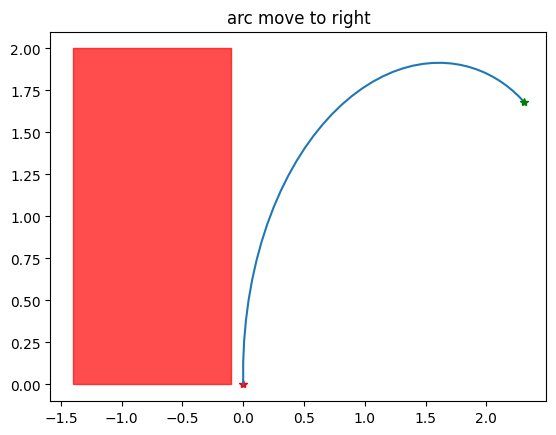

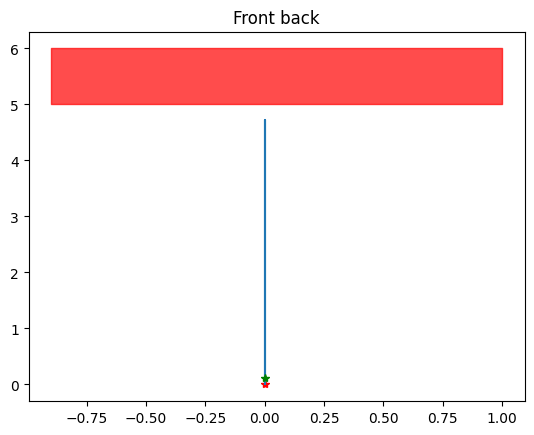

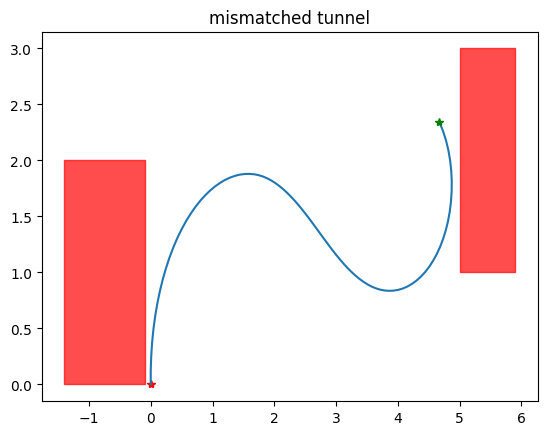

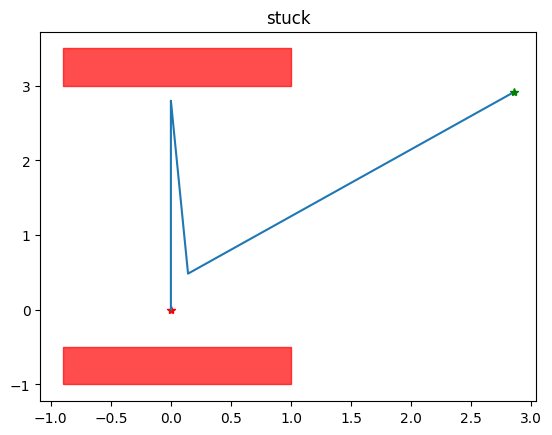

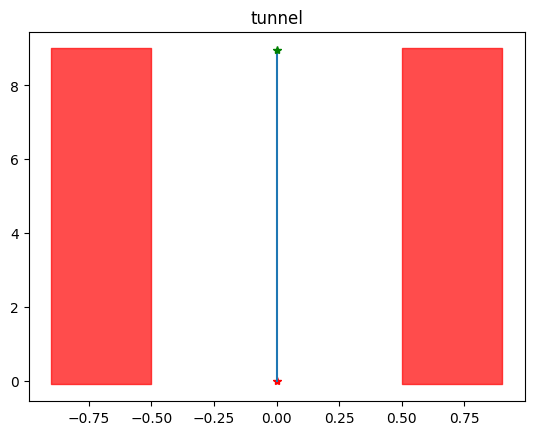

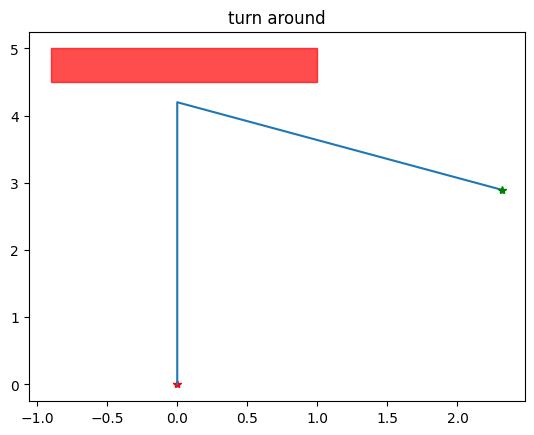

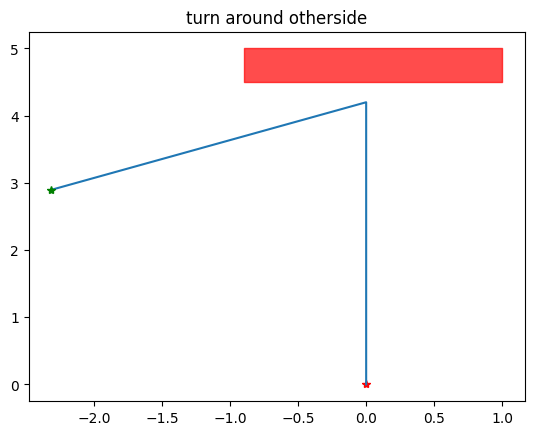

In [4]:
pos_x = list()
pos_y = list()

plt.title("arc move to left")
x,y = position(pwm_right[:120], pwm_left[:120])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.1,1.5,0.1), 0, 2, color='red', alpha=0.7)
plt.show()

plt.title("arc move to right")
x,y = position(pwm_right[120:240], pwm_left[120:240])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(-0.1,-1.5,-0.1), 0, 2, color='red', alpha=0.7)
plt.show()

plt.title("Front back")
x,y = position(pwm_right[240:360], pwm_left[240:360])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 5, 6, color='red', alpha=0.7)
plt.show()

plt.title("mismatched tunnel")
x,y = position(pwm_right[360:480], pwm_left[360:480])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(-0.1,-1.5,-0.1), 0, 2, color='red', alpha=0.7)
plt.fill_between(np.arange(5,6,0.1), 1, 3, color='red', alpha=0.7)
plt.show()

plt.title("stuck")
x,y = position(pwm_right[480:600], pwm_left[480:600])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 3, 3.5, color='red', alpha=0.7)
plt.fill_between(np.arange(1,-1,-0.1), -1, -0.5, color='red', alpha=0.7)
plt.show()

plt.title("tunnel")
x,y = position(pwm_right[600:720], pwm_left[600:720])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.5,1,0.1), -0.1, 9, color='red', alpha=0.7)
plt.fill_between(np.arange(-0.5,-1,-0.1), -0.1, 9, color='red', alpha=0.7)
plt.show()

plt.title("turn around")
x,y = position(pwm_right[720:840], pwm_left[720:840])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 4.5, 5, color='red', alpha=0.7)
plt.show()

plt.title("turn around otherside")
x,y = position(pwm_right[840:], pwm_left[840:])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 4.5, 5, color='red', alpha=0.7)
plt.show()

pos_x = np.array(sum(pos_x, []))
pos_y = np.array(sum(pos_y, []))

data = pd.DataFrame({'pwm left': np.array(pwm_left).reshape(-1,),
                     'pwm right': np.array(pwm_right).reshape(-1,),
                     'x position': np.array(pos_x).reshape(-1,),
                     'y position': np.array(pos_y).reshape(-1,)})

**proposed paths for training**

In [ ]:
pos_x = list()
pos_y = list()

plt.title("arc move to left")
x,y = position(pwm_right[:39], pwm_left[:39])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.1,1.5,0.1), 0, 2, color='red', alpha=0.7)
plt.show()

plt.title("arc move to right")
x,y = position(pwm_right[39:78], pwm_left[39:78])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(-0.1,-1.5,-0.1), 0, 2, color='red', alpha=0.7)
plt.show()

plt.title("Front back")
x,y = position(pwm_right[78:197], pwm_left[78:197])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 5, 6, color='red', alpha=0.7)
plt.show()

plt.title("mismatched tunnel")
x,y = position(pwm_right[197:286], pwm_left[197:286])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(-0.1,-1.5,-0.1), 0, 2, color='red', alpha=0.7)
plt.show()

plt.title("stuck")
x,y = position(pwm_right[286:381], pwm_left[286:381])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 3, 3.5, color='red', alpha=0.7)
plt.fill_between(np.arange(1,-1,-0.1), -1, -0.5, color='red', alpha=0.7)
plt.show()

plt.title("tunnel")
x,y = position(pwm_right[381:446], pwm_left[381:446])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(0.5,1,0.1), -0.1, 9, color='red', alpha=0.7)
plt.fill_between(np.arange(-0.5,-1,-0.1), -0.1, 9, color='red', alpha=0.7)
plt.show()

plt.title("turn around")
x,y = position(pwm_right[446:511], pwm_left[446:511])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 4.5, 5, color='red', alpha=0.7)
plt.show()

plt.title("turn around otherside")
x,y = position(pwm_right[511:], pwm_left[511:])
pos_x.append(x)
pos_y.append(y)
plt.fill_between(np.arange(1,-1,-0.1), 4.5, 5, color='red', alpha=0.7)
plt.show()

pos_x = np.array(sum(pos_x, []))
pos_y = np.array(sum(pos_y, []))

data = pd.DataFrame({'pwm left': np.array(pwm_left).reshape(-1,),
                     'pwm right': np.array(pwm_right).reshape(-1,),
                     'x position': np.array(pos_x).reshape(-1,),
                     'y position': np.array(pos_y).reshape(-1,)})

## Data preprocess

**Normalize**

In [5]:
def feature_normalizer_std(x):
    scaler = StandardScaler()
    if isinstance(x,pd.Series):
        x = scaler.fit_transform(x.values.reshape((-1,1)))
    else:
        for i in x.columns:
            x[i] = scaler.fit_transform(x[i].values.reshape((-1,1)))
    return x

def feature_normalizer_minmax(x):
    scaler = MinMaxScaler()
    if isinstance(x,pd.Series):
        x = scaler.fit_transform(x.values.reshape((-1,1)))
    else:
        for i in x.columns:
            x[i] = scaler.fit_transform(x[i].values.reshape((-1,1)))
    return x

In [ ]:
data = feature_normalizer_std(data)
data.head(5)

**Filtering**

In [ ]:
def lowpass(x,dt=1,taw=9):
    a = dt/(dt + taw)
    y = [0 for i in range(len(x))]
    y[0] = x[0]
    for i in range(len(x)-1):
        y[i+1] = y[i] + a*(x[i+1] - x[i])
    return y

**Disturbance rejection**

In [ ]:
def reject_dist(x_new,x_old):
    if (abs(x_old)>40):
        return x_old,x_old
    else:
        return x_new,x_old

## Identifier using KERAS

**preprocessing batches and time series**

In [8]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	x, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, -2:]
		x.append(seq_x)
		y.append(seq_y)
	return np.array(x), np.array(y)

# define input sequence
in_seq1 = np.array(data[["pwm left"]]).reshape(-1, 1)
in_seq2 = np.array(data[["pwm right"]]).reshape(-1, 1)
in_seq3 = np.array(data[["x position"]]).reshape(-1, 1)
in_seq4 = np.array(data[["y position"]]).reshape(-1, 1)
out_seq1 = np.array(data[["x position"]]).reshape(-1, 1)
out_seq2 = np.array(data[["y position"]]).reshape(-1, 1)

# convert to [rows, columns] structure
# in_seq1 = in_seq1.reshape((len(in_seq1), 1))
# in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# out_seq1 = out_seq1.reshape((len(out_seq1), 1))
# out_seq2 = out_seq2.reshape((len(out_seq2), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, in_seq4, in_seq4, out_seq1, out_seq2))
# convert into input/output (120 time steps as padded in the begining)
n_steps = 80
x_train_seq, y_train_seq = split_sequences(dataset, n_steps)
n_input = x_train_seq.shape[1] * x_train_seq.shape[2]
n_output = y_train_seq.shape[1]
for i in range(len(x)):
	print(x_train_seq[i], y_train_seq[i])

# flatten input
x_train_seq = x_train_seq.reshape((x_train_seq.shape[0], n_input))

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0.

**Network model**

In [12]:
model_NN = tf.keras.Sequential()
model_NN.add(tf.keras.layers.Input(n_input))
model_NN.add(tf.keras.layers.Dense(20,activation='tanh'))
model_NN.add(tf.keras.layers.Dense(n_output))

model_NN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                9620      
                                                                 
 dense_3 (Dense)             (None, 2)                 42        
                                                                 
Total params: 9,662
Trainable params: 9,662
Non-trainable params: 0
_________________________________________________________________


**Model fitting**

In [13]:
model_NN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse', metrics='mae')
# history = model_NN.fit(x_train,y_train,batch_size=8,validation_split=0.2,epochs=50)
history = model_NN.fit(x_train_seq,y_train_seq,batch_size=4,validation_split=0.2,epochs=20)

Epoch 1/20
176/176 [==============================] - 1s 3ms/step - loss: 2.3216 - mae: 1.0668 - val_loss: 1.5097 - val_mae: 0.9969
Epoch 2/20
176/176 [==============================] - 0s 2ms/step - loss: 1.9714 - mae: 0.9981 - val_loss: 1.0743 - val_mae: 0.7961
Epoch 3/20
176/176 [==============================] - 0s 2ms/step - loss: 1.9074 - mae: 0.9399 - val_loss: 1.5229 - val_mae: 0.9716
Epoch 4/20
176/176 [==============================] - 1s 4ms/step - loss: 1.8518 - mae: 0.9060 - val_loss: 1.5535 - val_mae: 0.8824
Epoch 5/20
176/176 [==============================] - 1s 4ms/step - loss: 1.8835 - mae: 0.9197 - val_loss: 1.1684 - val_mae: 0.8632
Epoch 6/20
176/176 [==============================] - 1s 3ms/step - loss: 1.8958 - mae: 0.9329 - val_loss: 1.2795 - val_mae: 0.8808
Epoch 7/20
176/176 [==============================] - 0s 2ms/step - loss: 1.7119 - mae: 0.8832 - val_loss: 1.4382 - val_mae: 0.9301
Epoch 8/20
176/176 [==============================] - 0s 2ms/step - loss: 1.

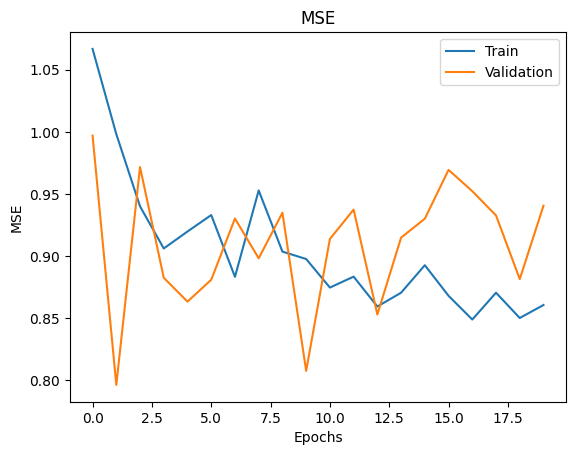

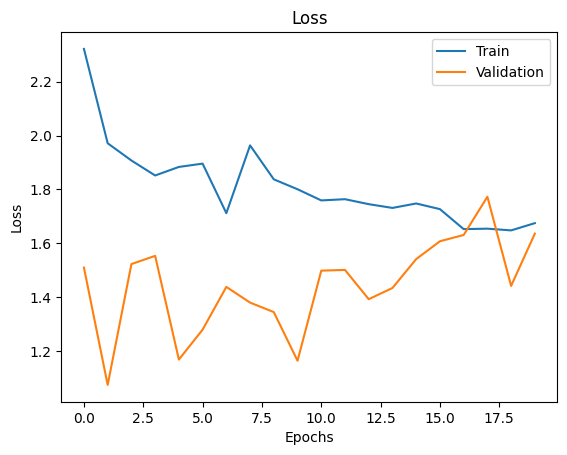

In [14]:
plt.figure()
plt.plot(history.history["mae"],label="Train")
plt.plot(history.history["val_mae"],label="Validation")
plt.title("MSE")
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.legend()
plt.figure()
plt.plot(history.history["loss"],label="Train")
plt.plot(history.history["val_loss"],label="Validation")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

**Evaluation and Test using a proposed map**

(20, 480)
1/1 [==============================] - 0s 46ms/step
[[ 0.02982271 -0.0543918 ]
 [-0.2197449   0.19642025]
 [-0.20737006  0.19705278]
 [ 0.45129007  0.2524627 ]
 [ 0.76020753  0.6064959 ]
 [ 0.79589474  1.295951  ]
 [ 0.79589486  1.2959524 ]
 [ 0.79589486  1.2959524 ]
 [ 0.79588866  1.2959619 ]
 [ 0.5230329   1.7170296 ]
 [ 0.5230329   1.7170296 ]
 [ 0.5230329   1.7170296 ]
 [ 0.7638241   2.0724328 ]
 [ 0.7638397   2.072456  ]
 [ 0.7638397   2.072456  ]
 [ 0.7638397   2.072456  ]
 [ 0.7638397   2.0724556 ]
 [ 0.7637302   2.0722942 ]
 [ 0.76381296  2.0724163 ]
 [ 0.76370704  2.07226   ]]


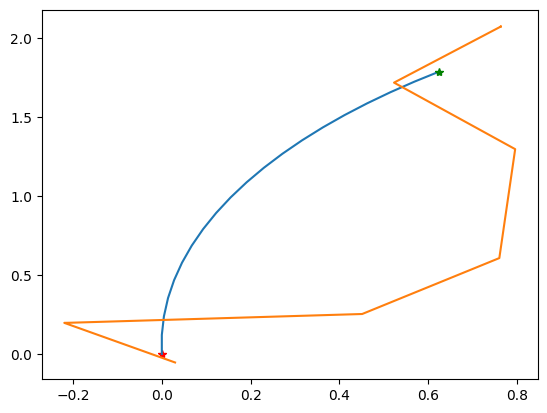

In [19]:
## moving in a tunnel
pwm_left = np.arange(70,50,-1)
pwm_right = np.arange(50,30,-1)
# pwm_right = np.ones((50,))*70
# pwm_left = np.ones((50,))*70
pwm_right = np.pad(pwm_right, (80,0), 'constant', constant_values=(0,))
pwm_left = np.pad(pwm_left, (80,0), 'constant', constant_values=(0,))
x,y= position(pwm_right, pwm_left)

test_data = pd.DataFrame({'pwm_left': np.array(pwm_left).reshape(-1,),
                          'pwm_right': np.array(pwm_right).reshape(-1,),
                          'x position': np.array(x).reshape(-1,),
                          'y position': np.array(y).reshape(-1,)})

in_seq1 = np.array(test_data[["pwm_left"]]).reshape(-1, 1)
in_seq2 = np.array(test_data[["pwm_right"]]).reshape(-1, 1)
in_seq3 = np.array(test_data[["x position"]]).reshape(-1, 1)
in_seq4 = np.array(test_data[["y position"]]).reshape(-1, 1)
out_seq1 = np.array(test_data[["x position"]]).reshape(-1, 1)
out_seq2 = np.array(test_data[["y position"]]).reshape(-1, 1)

# in_seq1 = in_seq1.reshape((len(in_seq1), 1))
# in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# out_seq1 = out_seq1.reshape((len(out_seq1), 1))
# out_seq2 = out_seq2.reshape((len(out_seq2), 1))

dataset = np.hstack((in_seq1, in_seq2, in_seq4, in_seq4, out_seq1, out_seq2))
# convert into input/output (120 time steps as padded in the begining)
x_test, y_test = split_sequences(dataset, n_steps)
n_input = x_test.shape[1] * x_test.shape[2]

x_test = x_test.reshape((x_test.shape[0], n_input))
print(x_test.shape)

# prediction = model_NN.predict(test_data[['pwm_left', 'pwm_right']])
prediction = model_NN.predict(x_test)
print(prediction)
plt.plot(prediction[:,0],prediction[:,1])

## Controller using KERAS

**modifing dataset for LSTM**

In [ ]:
LSTM_set = pd.DataFrame({
    "pwm left": [0.0],
    "pwm right": [0.0],
    "srf left": [0.0],
    "srf right": [0.0]},)

LSTM_set = LSTM_set.append(data)
LSTM_set[['srf left','srf right']] = LSTM_set[['srf left','srf right']].shift(-1)
LSTM_set = LSTM_set.dropna(axis=0)
LSTM_set.head(100)

In [ ]:
# Put inputs into a single list
LSTM_set['single_input_vector'] = LSTM_set[['srf left','srf right','pwm left','pwm right']].apply(tuple, axis=1).apply(list)
# Double-encapsulate list so we can sum it in the next step and keep time steps as separate elements
LSTM_set['single_input_vector'] = LSTM_set.single_input_vector.apply(lambda x: [list(x)])
# Using .cumsum() to include previous row vectors in the current row list of vectors (creating time series)
LSTM_set['cumulative_input_vectors'] = LSTM_set.single_input_vector.cumsum()

LSTM_set['output_vector'] = LSTM_set[['pwm left','pwm right']].apply(tuple, axis=1).apply(list)

LSTM_set.head(5)

In [ ]:
max_sequence_length = LSTM_set.cumulative_input_vectors.apply(len).max()
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(LSTM_set.cumulative_input_vectors.tolist(), max_sequence_length).tolist()
LSTM_set['padded_input_vectors'] = pd.Series(padded_sequences).apply(np.asarray)

LSTM_set.head(5)

In [ ]:
X_train_init = np.asarray(LSTM_set.padded_input_vectors)

# Use hstack to and reshape to make the inputs a 3d vector
X_train = np.hstack(X_train_init).reshape(len(LSTM_set),max_sequence_length,4)
y_train = np.hstack(np.asarray(LSTM_set.output_vector)).reshape(len(LSTM_set),2)

print(X_train_init.shape)
print(X_train.shape)

In [ ]:
# Input length is the length for one input sequence (i.e. the number of rows for your sample)
# Input dim is the number of dimensions in one input vector (i.e. number of input columns)
# Output dimensions is the shape of a single output vector
input_length = X_train.shape[1]
input_dim = X_train.shape[2]
output_dim = len(y_train[0])

In [ ]:
model_control = tf.keras.Sequential()
model_control.add(tf.keras.layers.LSTM(100, input_dim = input_dim, input_length = input_length))
model_control.add(tf.keras.layers.Dense(output_dim))
model_control.summary()

In [ ]:
model_control.compile(loss='mse',optimizer='sgd', metrics=['mae'])
history = model_control.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=100, verbose = 1)

In [ ]:
plt.figure()
plt.plot(history.history["mae"],label="Train")
plt.plot(history.history["val_mae"],label="Validation")
plt.title("mae")
plt.ylabel("mae")
plt.xlabel("Epochs")
plt.legend()
plt.figure()
plt.plot(history.history["loss"],label="Train")
plt.plot(history.history["val_loss"],label="Validation")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Identifier using equations

In [ ]:
def NN_identifier_train(u, x, eta1=0.5, eta2=0.5, p1=0.5, p2=0.5, Ts=0.001):
    '''given u and x are column vectors'''
    w_hat = np.random.random((1,10))
    w_hat_last = np.zeros(w_hat.shape)
    v_hat = np.random.random((10,2))
    v_hat_last = np.zeros(v_hat.shape)
    # x_hat = np.zeros(x[:,0].reshape(-1,1).shape)
    x_hat = x[:,0].reshape(-1,1)
    x_hat_last = np.zeros(x_hat.shape)
    x_bar = np.concatenate((x[:,0],u[:,0]),axis=0).reshape(-1,1)
    # x_bar_hat = np.zeros(x_bar.shape)
    x_bar_hat = np.concatenate((x_hat[:,0],u[:,0]),axis=0).reshape(-1,1)

    x_bar_hat_last = np.zeros(x_bar_hat.shape)

    for i in range(x.shape[1]):
        x_bar = np.concatenate((x[:,i],u[:,i]),axis=0).reshape(-1,1)
        x_tild = x[:,i].reshape(-1,1) - x_hat
        A = -np.eye(1)

        w_hat = (-eta1*
                    np.matmul(
                        (np.matmul(x_tild.T,np.linalg.inv(A))).T 
                            , (sigmoid(np.matmul(v_hat,x_bar_hat_last))).T ) 
                                - p1*np.linalg.norm(x_tild,2)*w_hat_last)*Ts +  w_hat_last
        
        v_hat = (np.matmul(-eta2*
                            (np.matmul(
                                np.matmul(
                                    np.matmul(x_tild.T,np.linalg.inv(A)),w_hat)
                                        ,(np.eye(10) - landa(np.matmul(v_hat_last,x_bar_hat_last))))).T,x_bar_hat_last.T) - p2*np.linalg.norm(x_tild,2)*v_hat_last)*Ts + v_hat_last
        
        x_hat = (np.matmul(A,x_hat_last) 
                    + np.matmul(w_hat,
                        sigmoid(np.matmul(v_hat,x_bar_hat_last))))*Ts + x_hat_last

        x_bar_hat = np.concatenate((x_hat,u[:,i].reshape(-1,1)),axis=0)
        x_bar_hat_last = x_bar_hat
        w_hat_last = w_hat
        v_hat_last = v_hat
    return (w_hat,v_hat,x_hat)

In [ ]:
def NN_model(w, v, x, activation = 'sig'):
    first_layer = np.matmul(v,x)
    if activation == 'sig':
        first_layer = sigmoid(first_layer)
    output = np.matmul(w,first_layer)
    return output